# Weak lensing – Notebook 2nd May 2024

Notebook tested with commit nb `xxx`.

Check requirements in `env.yml` (conda virtual environment).

The `pycs` package from the `cosmostat` repository (https://github.com/CosmoStat/cosmostat) could not be installed with `pip install .`. Therefore, the path to the git repository must be added to `PYTHONPATH` (see below). Tested with commit nb `a420193ced4bcd081f04a0afe0773aa4c120bfc8` (branch "hos").

The `pysparse` package from the `Sparse2D` repository  (https://github.com/CosmoStat/Sparse2D) needs to be manually installed. Tested with commit nb `3f9d54863765980299cfe92e0624ba93ed7ff02b`.

Very dirty workaround to avoid `ImportError: libpython3.11.so.1.0: cannot open shared object file: No such file or directory`: create a symbolic link from the `libpython3.11.so.1.0` file, which is typically stored in the `~/miniconda3/envs/wl-pycs/lib` (i.e., the directory for shared libraries within the virtual environment), to a standard root location such as `/lib/x86_64-linux-gnu`.

In [3]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys

import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import weaklensing as wl
import weaklensing.utils as wlutils
import weaklensing.cqr as wlcqr

pycs_dir = os.path.expanduser(wl.CONFIG_DATA['pycs_dir'])
sys.path.append(pycs_dir) # tested with commit nb b7b39124de0ad444a89e27123e1791400edfe748 (branch "hos-hl")
print(f"The `pycs` package is located in {pycs_dir}")

import pycs.astro.wl.mass_mapping as csmm

Configuration file found in /home/leterme231/OneDrive/Documents/Code/weaklensing
The `pycs` package is located in /home/leterme231/OneDrive/Documents/Code/cosmostat


## Figures for A&A paper

In [5]:
path_to_paper = os.path.expanduser("~/Dropbox/postdoc-hubert/papers/2024-04_AA/img")

### Convergence maps and noisy shear maps

In [6]:
%store -r extent width ra dec cosmos_mask ngal
%store -r kappa gamma1 gamma2 gamma1_noisy gamma2_noisy

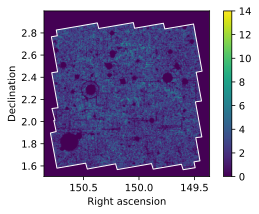

In [7]:
plt.figure(figsize=(5, 3))
wlutils.skyshow(
    ngal, extent=extent, boundaries=(ra, dec),
    #title="Number of galaxies per pixel"
)
plt.gcf().set_facecolor('none')
#plt.savefig(os.path.join(path_to_paper, "ngal.pdf"), bbox_inches='tight')
plt.show()

In [8]:
idx = 0
vmin = np.min(kappa)
vmax = np.max(kappa)
vmin_gamma = min(np.min(gamma1), np.min(gamma2))
vmax_gamma = max(np.max(gamma1), np.max(gamma2))
saturation = 0.4
saturation_gamma = 0.4

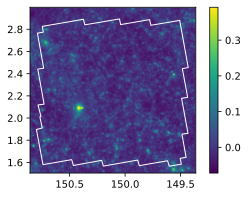

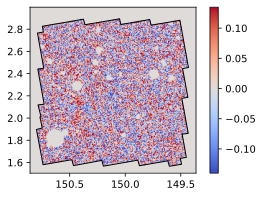

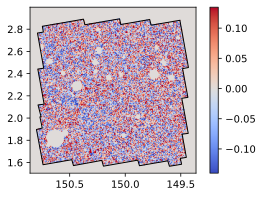

In [9]:
plt.figure(figsize=(5, 3))
wlutils.skyshow(
    kappa[idx], vmin=vmin, vmax=saturation*vmax, extent=extent,
    boundaries=(ra, dec), printxylabels=False
)
#plt.savefig(os.path.join(path_to_paper, "convmap.pdf"), bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 3))
wlutils.skyshow(
    gamma1_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', printxylabels=False
)
#plt.savefig(os.path.join(path_to_paper, "shearmap_re.pdf"), bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 3))
wlutils.skyshow(
    gamma2_noisy[idx], cmap='coolwarm', vmin=saturation_gamma*vmin_gamma, vmax=saturation_gamma*vmax_gamma,
    extent=extent, boundaries=(ra, dec), c='k', printxylabels=False
)
#plt.savefig(os.path.join(path_to_paper, "shearmap_im.pdf"), bbox_inches='tight')
plt.show()

### Examples of calibration functions

In [10]:
r = np.linspace(0, 0.08, 101)

#### Additive calibration functions (original paper)

$$g_\lambda(r) := \max(0,\, r + \lambda)$$

In [11]:
def g(lamb, r):
    return np.maximum(0, r + lamb)

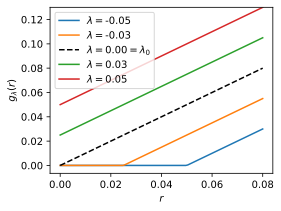

In [12]:
plt.figure(figsize=(4, 3))
for lamb in np.linspace(-.05, .05, 5):
    if lamb == 0.0:
        plt.plot(r, g(lamb, r), 'k--', label=r"$\lambda =$" + f"{lamb:.2f}" + r"$=\lambda_0$")
    else:
        plt.plot(r, g(lamb, r),  label=r"$\lambda =$" + f"{lamb:.2f}")
lamb = 4.
plt.xlabel(r"$r$")
plt.ylabel(r"$g_\lambda(r)$")
plt.ylim(top=0.13)
plt.legend()
#plt.savefig(os.path.join(path_to_paper, "calibfun_1.pdf"), bbox_inches='tight')
plt.show()

#### Multiplicative calibration functions

$$g_\lambda(r) := \lambda r$$

In [13]:
def g(lamb, r):
    return lamb * r

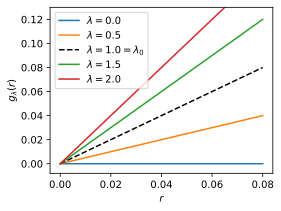

In [14]:
plt.figure(figsize=(4, 3))
for lamb in np.linspace(0., 2, 5):
    if lamb == 1.0:
        plt.plot(r, g(lamb, r), 'k--', label=r"$\lambda =$" + f"{lamb:.1f}" + r"$=\lambda_0$")
    else:
        plt.plot(r, g(lamb, r),  label=r"$\lambda =$" + f"{lamb:.1f}")
lamb = 4.
plt.xlabel(r"$r$")
plt.ylabel(r"$g_\lambda(r)$")
#plt.yticks(np.linspace(0, 0.16, 5))
plt.ylim(top=0.13)
plt.legend()
#plt.savefig(os.path.join(path_to_paper, "calibfun_2.pdf"), bbox_inches='tight')
plt.show()

#### Chi-squared calibration functions

$$g_{\lambda}(r) := r + b F_{\chi^2(k)}(r/a) (\lambda - 1),$$
where $F_{\chi^2}(k)$ denotes the cumulative distribution function of a chi-squared distribution with $k$ degrees of freedom.

In [15]:
def g(lamb, r, a=1, b=1, df=3):
    return r + b * stats.chi2.cdf(r / a, df) * (lamb - 1)

In [16]:
def plot_func_family(r, lambs, **kwargs):
    plt.figure(figsize=(4, 3))
    for lamb in lambs:
        if lamb == 1.0:
            plt.plot(
                r, g(lamb, r, **kwargs), 'k--',
                label=r"$\lambda =$" + f"{lamb:.1f}" + r"$=\lambda_0$"
            )
        else:
            plt.plot(
                r, g(lamb, r, **kwargs),
                label=r"$\lambda =$" + f"{lamb:.1f}"
            )
    plt.xlabel(r"$r$")
    plt.ylabel(r"$g_\lambda(r)$")
    plt.legend()
    plt.show()

In [17]:
def get_max_b(a=1, df=3):
    """
    Get the maximal value for parameter `b` (in order `g` to remain non-descending)

    """
    neg_chi2_pdf = lambda x: -stats.chi2.pdf(x, df)
    opt = optimize.minimize_scalar(neg_chi2_pdf)
    max_pdf = -opt.fun

    return a / max_pdf

In [18]:
a = 0.01
b = get_max_b(a=a)
print(f"a = {a} ==> b <= {b:.1e}")

a = 0.01 ==> b <= 4.1e-02


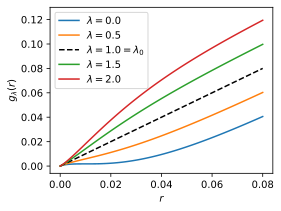

In [19]:
plt.figure(figsize=(4, 3))
for lamb in np.linspace(0., 2., 5):
    if lamb == 1.0:
        plt.plot(
            r, g(lamb, r, a=a, b=b), 'k--',
            label=r"$\lambda =$" + f"{lamb:.1f}" + r"$=\lambda_0$"
        )
    else:
        plt.plot(
            r, g(lamb, r, a=a, b=b),
            label=r"$\lambda =$" + f"{lamb:.1f}"
        )
plt.xlabel(r"$r$")
plt.ylabel(r"$g_\lambda(r)$")
plt.ylim(top=0.13)
plt.legend()
#plt.savefig(os.path.join(path_to_paper, "calibfun_3.pdf"), bbox_inches='tight')
plt.show()

### Load estimated convergence maps

In [20]:
%store -r kappa_ks kappa_wiener kappa_mcalens
%store -r res_ks res_wiener res_mcalens

### Visual representations (before calibration)

In [49]:
def skyshow_pred_bounds(pred, res, kappa, mask=None, showpred=True, savefig=True, filename=None):

    lowerbound = pred - res - kappa
    upperbound = pred + res - kappa
    if mask is not None:
        lowerbound *= mask
        upperbound *= mask

    if showpred:
        plt.figure(figsize=(5, 3))
        wlutils.skyshow(
            pred, vmin=vmin, vmax=saturation*vmax, extent=extent,
            boundaries=(ra, dec), printxylabels=False,
            printxticks=False, printyticks=False
        )
        if savefig:
            plt.savefig(os.path.join(path_to_paper, f"{filename}.pdf"), bbox_inches='tight')
        plt.show()

    plt.figure(figsize=(5, 3))
    wlutils.skyshow(
        lowerbound,
        cmap="coolwarm", vmin=-vmax_bounds, vmax=vmax_bounds,
        extent=extent, boundaries=(ra, dec),
        printcolorbar=False, printxylabels=False, printxticks=False, printyticks=False
    )
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(-.2, .2, 5)) 
    if savefig:
        plt.savefig(os.path.join(path_to_paper, f"{filename}_low.pdf"), bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(5, 3))
    wlutils.skyshow(
        upperbound,
        cmap="coolwarm", vmin=-vmax_bounds, vmax=vmax_bounds,
        extent=extent, boundaries=(ra, dec),
        printcolorbar=False, printxylabels=False, printxticks=False, printyticks=False
    )
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(-.2, .2, 5)) 
    if savefig:
        plt.savefig(os.path.join(path_to_paper, f"{filename}_high.pdf"), bbox_inches='tight')
    plt.show()

In [44]:
vmax_bounds = 0.23

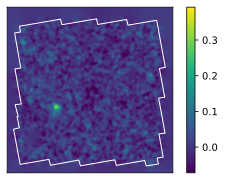

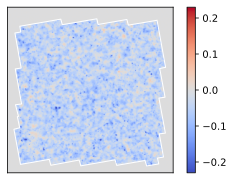

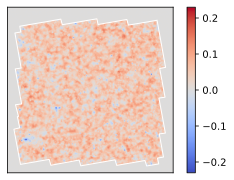

In [134]:
skyshow_pred_bounds(kappa_ks[idx], res_ks[idx], kappa[idx], mask=cosmos_mask, savefig=False, filename='ks')

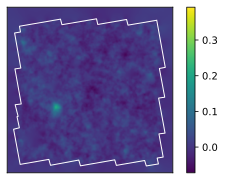

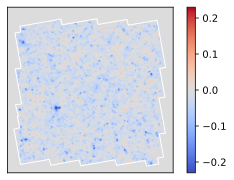

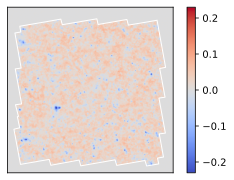

In [47]:
skyshow_pred_bounds(kappa_wiener[idx], res_wiener[idx], kappa[idx], mask=cosmos_mask, savefig=False, filename='wiener')

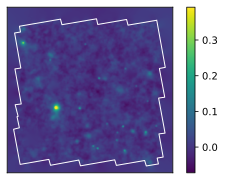

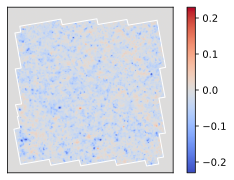

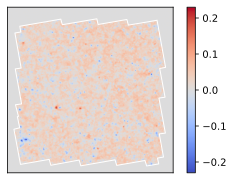

In [48]:
skyshow_pred_bounds(kappa_mcalens[idx], res_mcalens[idx], kappa[idx], mask=cosmos_mask, savefig=False, filename='mcalens')

### Split test and calibration sets

In [25]:
confidence = 2. # Level of confidence (n-sigma)
alpha = wlutils.get_alpha_from_confidence(confidence)

min_nimgs_calib = wlutils.get_min_nimgs_calib(alpha)
print(f"Confidence level of {confidence:.0f}-sigma --> alpha = {alpha:.1%}")
print(f"Smallest possible size for the calibration set = {min_nimgs_calib}")

Confidence level of 2-sigma --> alpha = 4.6%
Smallest possible size for the calibration set = 21


In [26]:
nimgs_calib = 100
nimgs = kappa.shape[0]
nimgs_test = nimgs - nimgs_calib
print(f"Size of the calibration set = {nimgs_calib}")
print(f"Size of the test set = {nimgs_test}")

Size of the calibration set = 100
Size of the test set = 125


In [27]:
[
    kappa_calib,
    kappa_ks_calib, kappa_wiener_calib, kappa_mcalens_calib,
    res_ks_calib, res_wiener_calib, res_mcalens_calib,
], [
    kappa_test,
    kappa_ks_test, kappa_wiener_test, kappa_mcalens_test,
    res_ks_test, res_wiener_test, res_mcalens_test,
] = \
    wlutils.split_test_calib([
        kappa,
        kappa_ks, kappa_wiener, kappa_mcalens,
        res_ks, res_wiener, res_mcalens,
    ], nimgs_calib, calib_first=False) # first the test set; then the calibration set

print(f"Size of the calibration set = {kappa_calib.shape[0]}")
print(f"Size of the test set = {kappa_test.shape[0]}")

Size of the calibration set = 100
Size of the test set = 125


### Quality of the estimated convergence maps

In [28]:
mse_ks_test = np.linalg.norm(kappa_ks_test - kappa_test, axis=(1, 2))**2
mse_wiener_test = np.linalg.norm(kappa_wiener_test - kappa_test, axis=(1, 2))**2
mse_mcalens_test = np.linalg.norm(kappa_mcalens_test - kappa_test, axis=(1, 2))**2

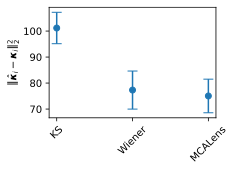

In [29]:
# Calculate mean and standard deviation for each statistical series
means = [np.mean(mse_ks_test), np.mean(mse_wiener_test), np.mean(mse_mcalens_test)]
std_devs = [np.std(mse_ks_test), np.std(mse_wiener_test), np.std(mse_mcalens_test)]

xticklabels = ["KS", "Wiener", "MCALens"]

plt.figure(figsize=(3, 2))

# Plot means with error bars representing standard deviations
plt.errorbar(np.arange(1, 4), means, yerr=std_devs, fmt='o', capsize=5)

plt.xticks(np.arange(1, 4), xticklabels, rotation=45)
plt.ylabel(r"$\left\|\hat{\boldsymbol{\kappa}}_i - \boldsymbol{\kappa}_i\right\|_2^2$")
#plt.savefig(os.path.join(path_to_paper, "mse.pdf"), bbox_inches='tight')
plt.show()

### Miscoverage rates and prediction interval before calibration

In [30]:
err_ks_test = wlutils.loss(
    kappa_ks_test - res_ks_test, kappa_ks_test + res_ks_test, kappa_test, mask=cosmos_mask
)
err_wiener_test = wlutils.loss(
    kappa_wiener_test - res_wiener_test, kappa_wiener_test + res_wiener_test, kappa_test, mask=cosmos_mask
)
err_mcalens_test = wlutils.loss(
    kappa_mcalens_test - res_mcalens_test, kappa_mcalens_test + res_mcalens_test, kappa_test, mask=cosmos_mask
)

In [31]:
predinterv_ks_test = wlutils.mean_predinterv(
    kappa_ks_test - res_ks_test, kappa_ks_test + res_ks_test, mask=cosmos_mask
)
predinterv_wiener_test = wlutils.mean_predinterv(
    kappa_wiener_test - res_wiener_test, kappa_wiener_test + res_wiener_test, mask=cosmos_mask
)
predinterv_mcalens_test = wlutils.mean_predinterv(
    kappa_mcalens_test - res_mcalens_test, kappa_mcalens_test + res_mcalens_test, mask=cosmos_mask
)

### CQR

In [87]:
def conformalize_get_metrics(
        cqr, pred_test, res_test, kappa_test, pred_calib, res_calib, kappa_calib,
        mask=None
):
    # Conformalize
    res_cqr_test, quantile_vals, _ = cqr.conformalize(
        res_test, pred_calib, res_calib, kappa_calib
    )

    # Discard quantile values outside the COSMOS boundaries
    if mask is not None:
        quantile_vals = quantile_vals[mask]

    kappa_lo_cqr_test = pred_test - res_cqr_test
    kappa_hi_cqr_test = pred_test + res_cqr_test

    # Error rate per image (over pixels)
    err_cqr_test = wlutils.loss(
        kappa_lo_cqr_test, kappa_hi_cqr_test, kappa_test, mask=mask
    )

    # Mean length of prediction intervals
    predinterv_cqr_test = wlutils.mean_predinterv(
        kappa_lo_cqr_test, kappa_hi_cqr_test, mask=mask
    )

    return res_cqr_test, err_cqr_test, predinterv_cqr_test

#### Additive CQR

In [88]:
addcqr = wlcqr.AddCQR(alpha)

In [90]:
res_ks_addcqr_test, err_ks_addcqr_test, predinterv_ks_addcqr_test = conformalize_get_metrics(
    addcqr, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
    mask=cosmos_mask
)

res_wiener_addcqr_test, err_wiener_addcqr_test, predinterv_wiener_addcqr_test = conformalize_get_metrics(
    addcqr, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
    mask=cosmos_mask
)

res_mcalens_addcqr_test, err_mcalens_addcqr_test, predinterv_mcalens_addcqr_test = conformalize_get_metrics(
    addcqr, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
    mask=cosmos_mask
)

#### Multiplicative CQR

In [91]:
multcqr = wlcqr.MultCQR(alpha)

In [92]:
res_ks_multcqr_test, err_ks_multcqr_test, predinterv_ks_multcqr_test = conformalize_get_metrics(
    multcqr, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
    mask=cosmos_mask
)

res_wiener_multcqr_test, err_wiener_multcqr_test, predinterv_wiener_multcqr_test = conformalize_get_metrics(
    multcqr, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
    mask=cosmos_mask
)

res_mcalens_multcqr_test, err_mcalens_multcqr_test, predinterv_mcalens_multcqr_test = conformalize_get_metrics(
    multcqr, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
    mask=cosmos_mask
)

#### Chi-squared CQR

In [95]:
chisqcqr = wlcqr.ChisqCQR(alpha, mask=cosmos_mask)

In [96]:
res_ks_chisqcqr_test = []
res_wiener_chisqcqr_test = []
res_mcalens_chisqcqr_test = []

err_ks_chisqcqr_test = []
err_wiener_chisqcqr_test = []
err_mcalens_chisqcqr_test = []

predinterv_ks_chisqcqr_test = []
predinterv_wiener_chisqcqr_test = []
predinterv_mcalens_chisqcqr_test = []

In [97]:
scalefacts = np.linspace(.004, .012, 5)
for a in scalefacts:
    chisqcqr.a = a

    res_ks_chisqcqr_test_0, err_ks_chisqcqr_test_0, predinterv_ks_chisqcqr_test_0 = conformalize_get_metrics(
        chisqcqr, kappa_ks_test, res_ks_test, kappa_test, kappa_ks_calib, res_ks_calib, kappa_calib,
        mask=cosmos_mask
    )
    res_ks_chisqcqr_test.append(res_ks_chisqcqr_test_0)
    err_ks_chisqcqr_test.append(err_ks_chisqcqr_test_0)
    predinterv_ks_chisqcqr_test.append(predinterv_ks_chisqcqr_test_0)

    res_wiener_chisqcqr_test_0, err_wiener_chisqcqr_test_0, predinterv_wiener_chisqcqr_test_0 = conformalize_get_metrics(
        chisqcqr, kappa_wiener_test, res_wiener_test, kappa_test, kappa_wiener_calib, res_wiener_calib, kappa_calib,
        mask=cosmos_mask
    )
    res_wiener_chisqcqr_test.append(res_wiener_chisqcqr_test_0)
    err_wiener_chisqcqr_test.append(err_wiener_chisqcqr_test_0)
    predinterv_wiener_chisqcqr_test.append(predinterv_wiener_chisqcqr_test_0)

    res_mcalens_chisqcqr_test_0, err_mcalens_chisqcqr_test_0, predinterv_mcalens_chisqcqr_test_0 = conformalize_get_metrics(
        chisqcqr, kappa_mcalens_test, res_mcalens_test, kappa_test, kappa_mcalens_calib, res_mcalens_calib, kappa_calib,
        mask=cosmos_mask
    )
    res_mcalens_chisqcqr_test.append(res_mcalens_chisqcqr_test_0)
    err_mcalens_chisqcqr_test.append(err_mcalens_chisqcqr_test_0)
    predinterv_mcalens_chisqcqr_test.append(predinterv_mcalens_chisqcqr_test_0)

In [98]:
list_of_err_ks_test = [
    err_ks_test, err_ks_addcqr_test, err_ks_multcqr_test, *err_ks_chisqcqr_test
]
list_of_err_wiener_test = [
    err_wiener_test, err_wiener_addcqr_test, err_wiener_multcqr_test, *err_wiener_chisqcqr_test
]
list_of_err_mcalens_test = [
    err_mcalens_test, err_mcalens_addcqr_test, err_mcalens_multcqr_test, *err_mcalens_chisqcqr_test
]

list_of_predinterv_ks_test = [
    predinterv_ks_test, predinterv_ks_addcqr_test, predinterv_ks_multcqr_test, *predinterv_ks_chisqcqr_test
]
list_of_predinterv_wiener_test = [
    predinterv_wiener_test, predinterv_wiener_addcqr_test, predinterv_wiener_multcqr_test,
    *predinterv_wiener_chisqcqr_test
]
list_of_predinterv_mcalens_test = [
    predinterv_mcalens_test, predinterv_mcalens_addcqr_test, predinterv_mcalens_multcqr_test,
    *predinterv_mcalens_chisqcqr_test
]

#### Visual representations

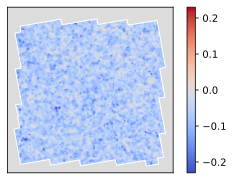

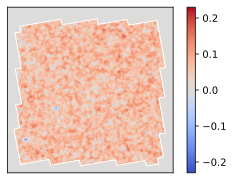

In [100]:
skyshow_pred_bounds(
    kappa_ks_test[idx], res_ks_addcqr_test[idx], kappa_test[idx], mask=cosmos_mask,
    showpred=False, savefig=True, filename='ks_addcqr'
)

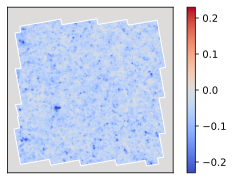

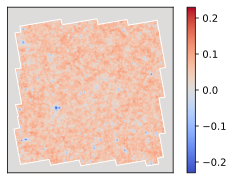

In [101]:
skyshow_pred_bounds(
    kappa_wiener_test[idx], res_wiener_addcqr_test[idx], kappa_test[idx], mask=cosmos_mask,
    showpred=False, savefig=True, filename='wiener_addcqr'
)

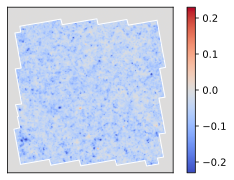

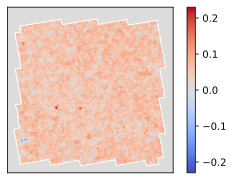

In [102]:
skyshow_pred_bounds(
    kappa_mcalens_test[idx], res_mcalens_addcqr_test[idx], kappa_test[idx], mask=cosmos_mask,
    showpred=False, savefig=True, filename='mcalens_addcqr'
)

#### Plot graphs

In [103]:
def plot_means_errs(means, stds, ylabel, drawtarget=True, savefig=True, filename=None):
    """
    Plot means with error bars representing standard deviations
    
    """
    nvals = len(means)

    plt.figure(figsize=(6, 2))
    plt.errorbar(np.arange(nvals) + 1, means, yerr=stds, fmt='.', capsize=5)

    plt.xticks(np.arange(nvals) + 1, xticklabels, rotation=45)
    plt.ylabel(ylabel)
    if drawtarget:
        plt.axhline(y=alpha, color='red', linestyle='--', linewidth=0.8, label=r'$\alpha$ (target)')
        plt.legend()
    if savefig:
        plt.savefig(os.path.join(path_to_paper, f"{filename}.pdf"), bbox_inches='tight')
    plt.show()

In [104]:
xticklabels = [
    "Uncalibrated", r"Additive", r"Multiplicative", r"$\chi^2$, $a =$.004", r"$\chi^2$, $a =$.006",
    r"$\chi^2$, $a =$.008", r"$\chi^2$, $a =$.010", r"$\chi^2$, $a =$.012"
]

- Miscoverage rate

In [105]:
ylabel_err = r"$L\left(\boldsymbol{\kappa}_i,\, \hat{\boldsymbol{\kappa}}_i^-,\, \hat{\boldsymbol{\kappa}}_i^+\right)$"

In [106]:
# Calculate mean and standard deviation for each statistical series
means_err_ks = [np.mean(err) for err in list_of_err_ks_test]
stds_err_ks = [np.std(err) for err in list_of_err_ks_test]

means_err_wiener = [np.mean(err) for err in list_of_err_wiener_test]
stds_err_wiener = [np.std(err) for err in list_of_err_wiener_test]

means_err_mcalens = [np.mean(err) for err in list_of_err_mcalens_test]
stds_err_mcalens = [np.std(err) for err in list_of_err_mcalens_test]

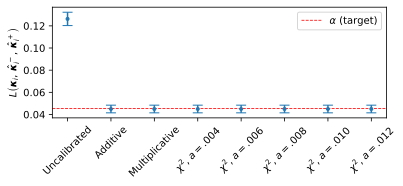

In [107]:
plot_means_errs(means_err_ks, stds_err_ks, ylabel_err, savefig=False, filename="errs_ks")

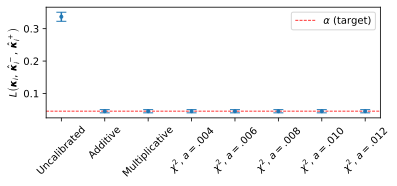

In [108]:
plot_means_errs(means_err_wiener, stds_err_wiener, ylabel_err, savefig=False, filename="errs_wiener")

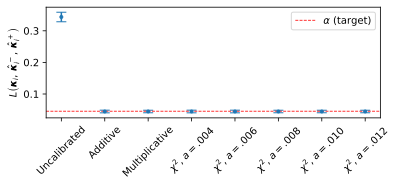

In [109]:
plot_means_errs(means_err_mcalens, stds_err_mcalens, ylabel_err, savefig=False, filename="errs_mcalens")

- Mean length of prediction intervals

In [110]:
ylabel_predinterv = r"$\left\langle \hat{\boldsymbol{\kappa}}_i^+ - \hat{\boldsymbol{\kappa}}_i^- \right\rangle$"

In [111]:
# Calculate mean and standard deviation for each statistical series
means_predinterv_ks = [np.mean(predinterv) for predinterv in list_of_predinterv_ks_test]
stds_predinterv_ks = [np.std(predinterv) for predinterv in list_of_predinterv_ks_test]

means_predinterv_wiener = [np.mean(predinterv) for predinterv in list_of_predinterv_wiener_test]
stds_predinterv_wiener = [np.std(predinterv) for predinterv in list_of_predinterv_wiener_test]

means_predinterv_mcalens = [np.mean(predinterv) for predinterv in list_of_predinterv_mcalens_test]
stds_predinterv_mcalens = [np.std(predinterv) for predinterv in list_of_predinterv_mcalens_test]

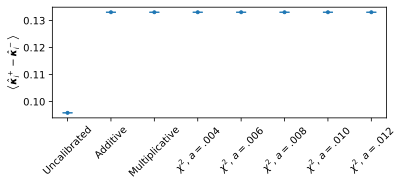

In [112]:
plot_means_errs(
    means_predinterv_ks, stds_predinterv_ks, ylabel_predinterv, drawtarget=False,
    savefig=False, filename="predinterv_ks"
)

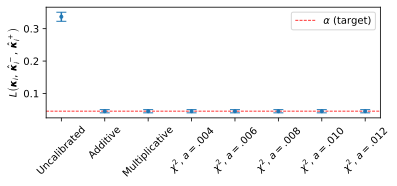

In [113]:
plot_errs(means_err_wiener, stds_err_wiener, "errs_wiener")

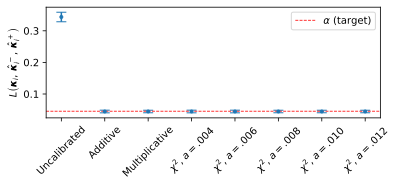

In [ ]:
plot_errs(means_err_mcalens, stds_err_mcalens, "errs_mcalens")